# Regression Transformer Model
Predicts the number of comments an article will get based on the article's topic, tone, length, hour of the day and day of the week

In [102]:
import tensorflow as tf
from keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense, Flatten
from keras.datasets import imdb
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [103]:
# Implementation of Transformer encoder from scratch in TensorFlow and Keras
# By Jason Brownlee on February 24, 2021
# Available at https://machinelearningmastery.com/implementing-the-transformer-encoder-from-scratch-in-tensorflow-and-keras/
def encoder_block(embed_dim, num_heads, ff_dim, dropout_rate):
    # initalise all of the layers
    multihead_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    feed_forward = Sequential(
        [Dense(ff_dim, activation="relu"),
         Dense(embed_dim), ]
    )
    add_norm = LayerNormalization(epsilon=1e-6)
    dropout = Dropout(dropout_rate)
    
    # apply the encoder block to input data
    def call(inputs, training):
        attn_output = multihead_attention(inputs, inputs)
        attn_output = dropout(attn_output, training=training)
        out1 = add_norm(inputs + attn_output)
        feedforward_output = feed_forward(out1)
        feedforward_output = dropout(feedforward_output, training=training)
        return add_norm(out1 + feedforward_output)
    
    return call

In [104]:
# Implementation of Transformer decoder from scratch in TensorFlow and Keras
# By Jason Brownlee on February 24, 2021
# Available at https://machinelearningmastery.com/implementing-the-transformer-decoder-from-scratch-in-tensorflow-and-keras/
def decoder_block(num_heads, embed_dim, ff_dim, dropout_rate):
    # initialise the layers
    multihead_attention1 = MultiHeadAttention(num_heads, embed_dim, embed_dim)
    dropout1 = Dropout(dropout_rate)
    add_norm1 = LayerNormalization(epsilon=1e-6)
    
    multihead_attention2 = MultiHeadAttention(num_heads, embed_dim, embed_dim)
    dropout2 = Dropout(dropout_rate)
    add_norm2 = LayerNormalization(epsilon=1e-6)
    
    feed_forward = Sequential(
        [Dense(ff_dim, activation="relu"),
         Dense(embed_dim), ]
    )
    dropout3 = Dropout(dropout_rate)
    add_norm3 = LayerNormalization(epsilon=1e-6)
    
    # apply the decoder block to encoder output
    def call(inputs, encoder_output, training):
        multihead_output1 = multihead_attention1(inputs, inputs, inputs)
        multihead_output1 = dropout1(multihead_output1)
        addnorm_output1 = add_norm1(inputs + multihead_output1)
        multihead_output2 = multihead_attention2(addnorm_output1, encoder_output, encoder_output)
        multihead_output2 = dropout2(multihead_output2)
        addnorm_output2 = add_norm2(addnorm_output1 + multihead_output2)
        feedforward_output = feed_forward(addnorm_output2)
        feedforward_output = dropout3(feedforward_output)

        return add_norm3(addnorm_output2 + feedforward_output)

    return call

In [107]:
#Load training data
train_df = pd.read_csv('../../data/regression_train.csv')

# Extract the columns you want to use as input features
columns = ['BERT_sentiment_score', 'normalised_word_count', 'pub_day', 'pub_hour', 'topic']
# Extract input features from the dataframe
x_train = np.array(train_df[columns])

y_train = np.array(train_df['n_comments'])

In [108]:
# Training and validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [109]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_mae', 
                               # Number of epochs to wait for improvement
                               patience=10,  
                               verbose=1, 
                               # Restore the weights of the best epoch
                               restore_best_weights=True)

In [110]:
# Hypreparameters
max_seq_length = x_train.shape[1]
vocab_size = int(np.max(x_train) + 1)
embedding_dim = 32
num_heads = 2
ff_dim = 32
dropout_rate = 0.1

In [111]:
# Define model architecture

# Input 
inputs = Input(shape=(max_seq_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

# Encoder
encoder_block_fn = encoder_block(embed_dim=embedding_dim, 
                                 num_heads=num_heads, 
                                 ff_dim=ff_dim,
                                 dropout_rate=dropout_rate)
encoder_output = encoder_block_fn(embedding_layer, training=True)

# Decoder
decoder_block_fn = decoder_block(num_heads=num_heads,
                                 embed_dim=embedding_dim,
                                 ff_dim=ff_dim,
                                 dropout_rate=dropout_rate)
decoder_output = decoder_block_fn(inputs=encoder_output, 
                                  encoder_output=encoder_output,
                                  training=True)

# Pooling and Dropout
pooling_layer = GlobalAveragePooling1D()(decoder_output)
dropout_layer = Dropout(dropout_rate)(pooling_layer)

# Output
outputs = Dense(units=1, activation='linear')(dropout_layer)  # Change activation to 'linear' for regression

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 5, 32)        2688        ['input_9[0][0]']                
                                                                                                  
 multi_head_attention_22 (Multi  (None, 5, 32)       8416        ['embedding_8[0][0]',            
 HeadAttention)                                                   'embedding_8[0][0]']            
                                                                                                  
 dropout_42 (Dropout)           (None, 5, 32)        0           ['multi_head_attention_22[0

In [112]:
# Compile the model
model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])  # Change loss function to 'mse' for regression

# Train the model
history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val), 
          callbacks=[early_stopping])

Epoch 1/100
125/125 [==============================] - 5s 16ms/step - loss: 373670.3438 - mae: 302.6809 - val_loss: 320835.6875 - val_mae: 274.2800
Epoch 2/100
125/125 [==============================] - 1s 11ms/step - loss: 368354.9375 - mae: 297.2778 - val_loss: 315178.1250 - val_mae: 268.9429
Epoch 3/100
125/125 [==============================] - 2s 12ms/step - loss: 361048.8438 - mae: 291.9463 - val_loss: 307745.6250 - val_mae: 264.1726
Epoch 4/100
125/125 [==============================] - 1s 12ms/step - loss: 352296.3438 - mae: 287.6805 - val_loss: 299224.1875 - val_mae: 261.0049
Epoch 5/100
125/125 [==============================] - 1s 12ms/step - loss: 342375.4375 - mae: 284.1320 - val_loss: 290048.0938 - val_mae: 257.9385
Epoch 6/100
125/125 [==============================] - 2s 13ms/step - loss: 332132.4688 - mae: 280.8217 - val_loss: 280687.9062 - val_mae: 255.5082
Epoch 7/100
125/125 [==============================] - 2s 16ms/step - loss: 321595.5000 - mae: 277.9090 - val_lo

In [113]:
# save the trained model
model.save('../transformer_regression_model.h5')

In [114]:
model = load_model('../transformer_regression_model.h5')

In [115]:
# Evaluate the model on validation data
mse, mae = model.evaluate(x_val, y_val)
print('Validation MSE:', mse)
print('Validation MAE:', mae)

63/63 [==============================] - 1s 4ms/step - loss: 170314.9219 - mae: 220.6639
Validation MSE: 170314.921875
Validation MAE: 220.6638946533203


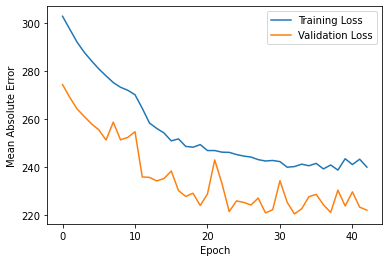

In [116]:
# plot the training and validation loss
plt.plot(history.history['mae'], label='Training Loss')
plt.plot(history.history['val_mae'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()